# APS PYTHON PARA CIÊNCIA DE DADOS

Integrantes:
- Daniel Costa Delattre 
- Dener Vilarinho
- Renan Buck
- Gabriel Peres Afonso


## Objetivo 
O propósito desse trabalho é modelar preço de uma casa conforme suas características disponíveis no Dataset utilizado. Segundo a publicação de João Pedro Pinheiro Malere, Publio Netto de Almeida e Humberto Hayashi Sano, __a utilização de modelos em aprendizagem de máquina para o modelo imobiliário tem sido realizada de maneira extensiva__, isso é possível dado o avanço da área da computação. A finalidade de se ter um modelo preditivo para preços de casa é obter uma forma de automatizar o processo de avaliação do preço de uma casa quando um possível cliente quer colocar seu imóvel a venda, assim, poupando tempo de decisão e de análise, mas executando-a de maneira confiável. 

Carregando algumas bibliotecas:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from plotnine import *
import os, csv, string, re
import statsmodels.api as sm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor


In [2]:
### Função utilitária para fazer a regressão linear com constante adicionada
def regress(X,Y):
    '''
    X: coluna(s) do DataFrame que serão utilizadas como variável(is) preditoras/explicativas (independente(s))
    Y: coluna do DataFrame que será utilizada como variável resposta (dependente)
    '''
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

#função para calcular a acurácia
def evaluate(model, test_features, test_labels):
    #faz a predição do valor das casa utilizando o modelo
    predictions = model.predict(test_features)
    #tira o erro absoluto entre valor previsto e o real
    errors = abs(predictions - test_labels)
    #Porcentagem média do erro absoluto
    mape = 100 * np.mean(errors / test_labels)
    #Acurácia do modelo
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: ${:0.2f} .'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    # rf_random.fit(xtreino, ytreino)
    return accuracy

def load_data():
    ROOT = 'data'
    fname = 'kc_house_data.csv'
    fpath = f'{ROOT}/{fname}'
    df = pd.read_csv(fpath).drop(['date','zipcode'], axis=1)
    return df

#### Carregando a base de dados de teste e de treino e excluindo as colunas date e zipcode (pois não serão usadas nas análise):

In [3]:
df = load_data()

In [4]:
#Printando as colunas que temos na variável do dataset
df.columns.to_list()

['id',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

Mas afinal, o que cada uma delas significa?
- **ID:**          Numero identificação da casa 
- **Price:**       Preço
- **Bedrooms:**    Número de quartos
- **Bathrooms:**   Números de banheiros
- **Sqft_living:** Área habitável
- **Sqft_lot:**    Tamanho do terreno
- **Floors:**      Andares
- **Waterfront:**  Se tem vista para o mar
- **View:** Nota para a vista 0-4
- **Condition:** Condição 0-5
- **Grade:** Classificação 
- **Sqft_above:** Metros quadrados que descontados o porão
- **Sqft_basement:** Tamanho do porão 
- **Yr_built:** Ano de construção
- **Yr_renovated:** Ano de reconstrução/reforma
- **Lat:** Latitude
- **Long:** Longitude
- **Sqft_living15:** Metros quadrados habitáveis no ano de 2015
- **Sqft_lot15:** Metros quadrados do terreno todo no ano de 2015

Verificando se não existe linhas sem dados/informação

In [5]:
np.sum(df.isnull())

id               0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## Visualizando o dataset

In [6]:
df.head(10)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503
5,7237550310,1225000.0,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,47.6561,-122.005,4760,101930
6,1321400060,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,47.3097,-122.327,2238,6819
7,2008000270,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,47.4095,-122.315,1650,9711
8,2414600126,229500.0,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,47.5123,-122.337,1780,8113
9,3793500160,323000.0,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,47.3684,-122.031,2390,7570


#### Removendo Outliers


In [7]:
def remove_outliers(df_):
    df = df_.copy()
    #Criando o Isolation Forest
    clf = IsolationForest(max_samples = 110, random_state = 42)
    # Isolation forest retorna o score de anomalia de cada sampl

    #treinando o modelo
    clf.fit(df)
    y_semout = clf.predict(df)
    y_semout = pd.DataFrame(y_semout, columns = ['Top'])
    #processo para remover as linhas com outliers do banco de dados
    mask_remove_outliers = y_semout[y_semout['Top'] == 1].index.values
    df = df.iloc[mask_remove_outliers]
    df.reset_index(drop=True, inplace=True)
    
    print("Número de outliers:", y_semout[y_semout['Top'] == -1].shape[0])
    print("Número de colunas sem outliers:", df.shape[0])
    df.drop('id', axis=1, inplace=True)
    df.fillna(0, inplace=True)
    return df

df = remove_outliers(df)

Número de outliers: 3079
Número de colunas sem outliers: 18534


# Analise exploratória 

Para visualizar o comportamento de cada variável do dataset (preço, número de banheiros, números de quartos, área da casa e do seu terreno, etc) foram plotados gráficos para identificar a distribuição de cada uma delas dentro do dataset. Além disso, como a variável de interesse para prever é o preço de casas, foram plotados alguns gráficos para visualizar a interação entre a coluna de preços das casas e as demais colunas. 

## Distribuição de cada variável

Abaixo está os gráficos da distribuição de cada variável, exceto da coluna com os preços, ela será analisada posteriormente:

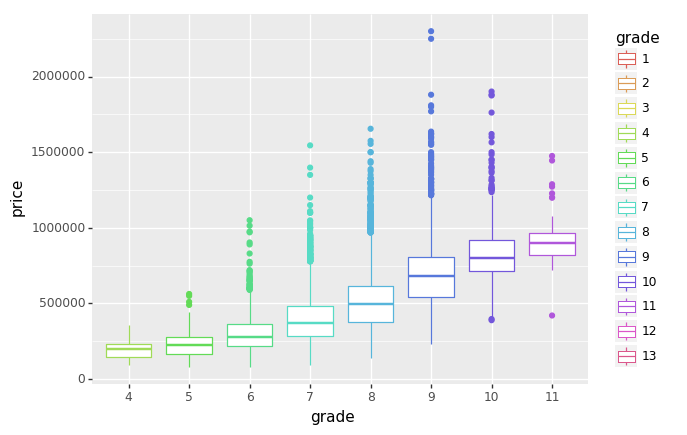

<ggplot: (8756110580541)>

In [8]:
df_test = df.copy()
df_test =  df_test.assign(
    grade = lambda _: pd.Categorical(_.grade, [1,2,3,4,5,6,7,8,9,10,11,12,13]))
(ggplot(df_test, aes(x='grade', y = 'price',color ='grade'))+
 geom_boxplot())


## GRADE - Avaliação dos imoveis

Nota-se pela a análise de boxplots, conforme a nota sobe a média do preço dos ativos também aumenta, ou seja, é plausível supor que imóveis com melhores avaliações sejam tambem imóveis mais caros.

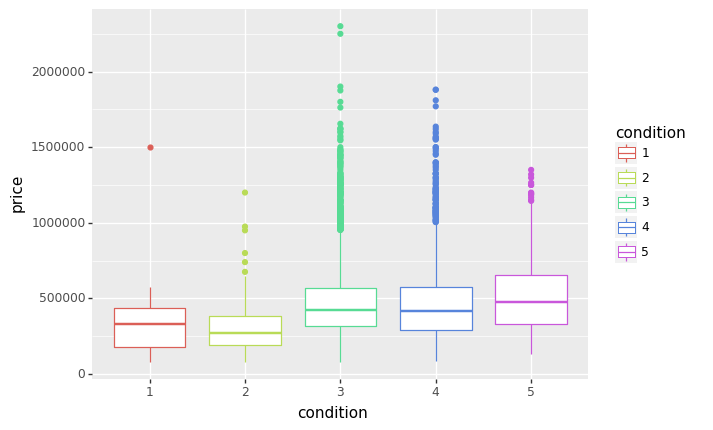

<ggplot: (8756107965149)>

In [9]:
df_test = df.copy()
df_test =  df_test.assign(
    condition = lambda _: pd.Categorical(_.condition, [1,2,3,4,5]))
(ggplot(df_test, aes(x='condition', y = 'price',color ='condition'))+
 geom_boxplot())



## Condition - Condições dos imóveis

Nesse caso, o gráfico não consegue nos dizer se uma boa condição levaria a um maior preço, devido a não ter mais informações sobre tamanho e etc.

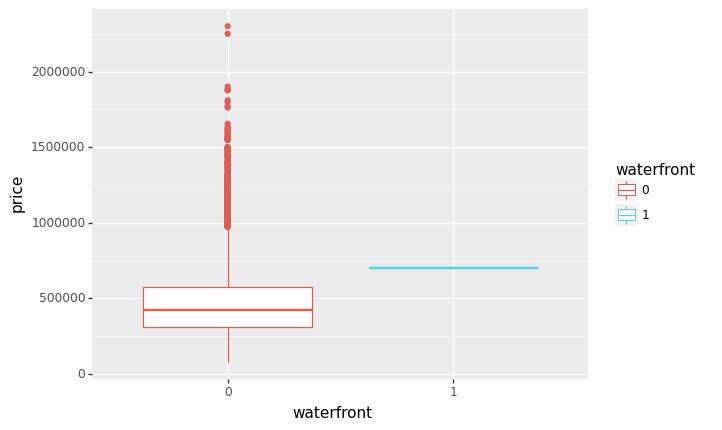

<ggplot: (8756107913009)>

In [10]:
df_test = df.copy()
df_test =  df_test.assign(
    waterfront = lambda _: pd.Categorical(_.waterfront, [0,1]))
(ggplot(df_test, aes(x='waterfront', y = 'price',color ='waterfront'))+
 geom_boxplot())

## Waterfront - Vista para o mar

Ao realizar a análise de vista do mar em relação ao preço, percebe-se que o fato de o imóvel ter vista para o mar impacta de maneira geral no preço do ativo.

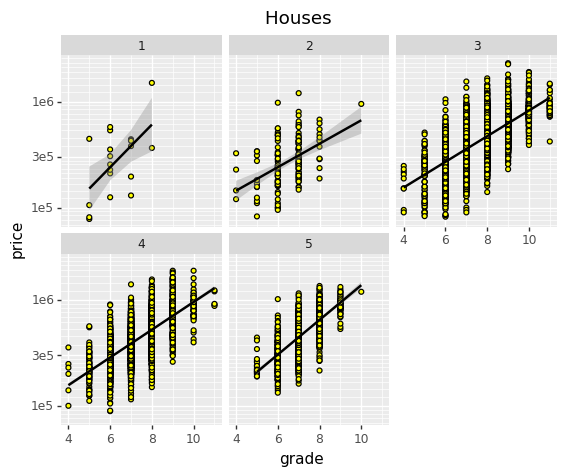

<ggplot: (8756107952891)>

In [11]:
(ggplot(df, aes(x='grade', y = 'price'))+
 geom_point(fill = 'yellow')+
 scale_y_log10()+
 geom_smooth()+
 labs(x = 'grade', y = 'price', title = 'Houses ')+
 facet_wrap('~ condition'))

## Grade, Price and Condition

Olhando para a nota em cada tipo de condição de imóvel, é possível inferir, independente da condição do imóvel que conforme a nota melhora o preço do ativo aumenta.


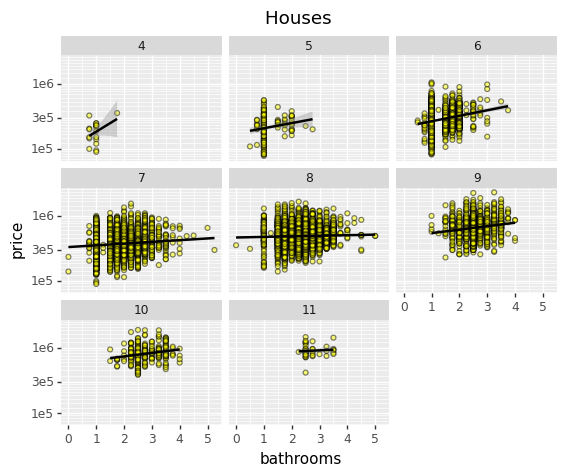

<ggplot: (8756229582716)>

In [12]:
# Impactos do número de quartos nos preços das casas 
(ggplot(df, aes(x='bathrooms', y = 'price'))+
 geom_point(fill = 'yellow', alpha = 0.5)+
 scale_y_log10()+
 geom_smooth()+
 labs(x = 'bathrooms', y = 'price', title = 'Houses ')+
 facet_wrap('~ grade'))

## Grade, Bathrooms and Price

Olhando para a quantidade de banheiro em cada faixa de nota da avaliação do imóvel, é possível visualizar que conforme a quantidade de banheiros aumenta no imóvel o preço do imóvel aumenta


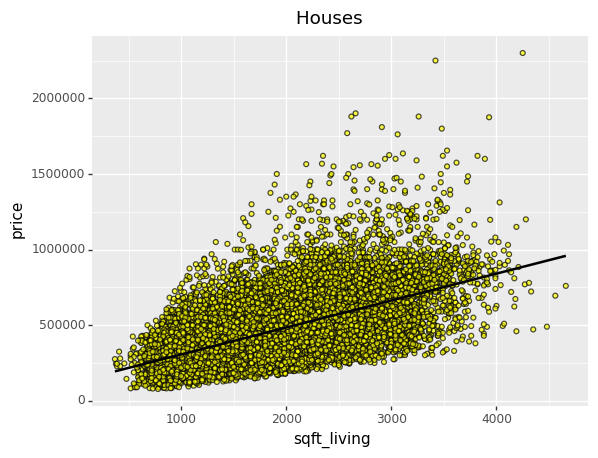

<ggplot: (8756105211466)>

In [13]:
(ggplot(df, aes(x = 'sqft_living', y = 'price')) +
    geom_point(alpha = 0.7, fill = 'yellow')+
     geom_smooth()+
     labs(x = 'sqft_living', y = 'price', title = 'Houses ')
)

## sqft_living - Área habitável

Ao analisar a relação entre tamanho da área habitável e preço, é possível inferir que conforme a área habitável aumenta o preço do imóvel também aumenta

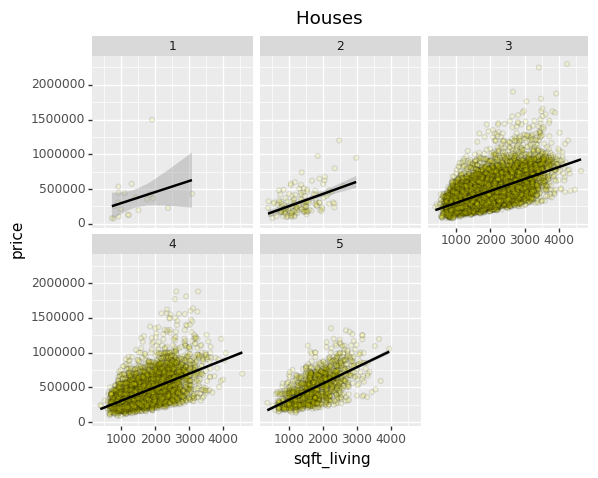

<ggplot: (8756107477851)>

In [14]:
(ggplot(df, aes(x = 'sqft_living', y = 'price')) +
    geom_point(alpha = 0.1, fill = 'yellow')+
    geom_smooth()+
     labs(x = 'sqft_living', y = 'price', title = 'Houses ')+
    facet_wrap('~ condition') +
    theme(legend_position = 'none')
)

## sqft_living, condition, price
Separando em níveis de condições, é possível visualizar que independente da faixa de condição, conforme a área habitável aumenta o preço também aumenta

# Predições 

## - Regressão Linear Multipla

Assim como o próprio nome induz, o método faz a predição da variável de interesse (dependente) a partir de uma função linear com para cada uma das demais variáveis (independentes). A imagem abaixo apresenta a lei de formação da função:


Essa função descreve a relação entre as variáveis de forma que a distância de cada relação com a função seja a menor possível, isso é feito por meio da minimização dos resíduos. O resíduo é a distância entro o valor da variável de interesse real do valor previsto pela função obtida. O cálculo do resíduo é feito por meio do Método dos Mínimos Quadrados (MMQ) ou, em inglês, Ordinary Least Squares.

Definindo variável de interesse (preço) e demais que serão base para a predição:

<img src="img/regressãolinear.png" />

Essa função descreve a relação entre as variáveis de forma que a distância de cada relação com a função seja a menor possível, isso é feito por meio da minimização dos resíduos. O resíduo é a distância entro o valor da variável de interesse real do valor previsto pela função obtida. O cálculo do resíduo é feito por meio do **Método dos Mínimos Quadrados (MMQ)** ou, em inglês, **Ordinary Least Squares**.

Definindo variável de interesse (preço) e demais que serão base para a predição:


In [15]:
#A variável de interesse é o preço, por isso selecionamos esta coluna no dataset
Y = df['price']
#A variáveis dependentes serão bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, 
#grade, sqft_above,sqft_basement, yr_built, yr_renovated, lat, long, sqft_living15, sqft_lot15
X = df[['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','waterfront', 'condition', 'view', 'grade', 'sqft_above','sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long']]

In [16]:
#Printando as colunas que estão em X, apenas para confirmação
X.columns.tolist()

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'condition',
 'view',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'lat',
 'long']

In [17]:
results = regress(X,Y)

#Os resultados obtidos serão visualizados na tabela a seguir
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     2268.
Date:                Thu, 17 Nov 2022   Prob (F-statistic):               0.00
Time:                        10:48:10   Log-Likelihood:            -2.4429e+05
No. Observations:               18534   AIC:                         4.886e+05
Df Residuals:                   18519   BIC:                         4.887e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -2.1e+07   1.14e+06    -18.407      0.000   -2.32e+07   -1.88e+07
bedrooms      -1.271e+04   1375.582     -9.241      0.000   -1.54e+04      -1e+04
bathrooms      2.545e+04   2434.765     10.454      0.000    2.07e+04    3.02e+04
sqft_living      69.3136      1.744     39.750      0.000      65.896      72.732
sqft_lot         -0.3655      0.106     -3.441      0.001      -0.574      -0.157
floors          2.01e+04   2591.726      7.755      0.000     1.5e+04    2.52e+04
waterfront      1.82e+05   1.29e+05      1.416      0.157      -7e+04    4.34e+05
condition      2.585e+04   1625.747     15.897      0.000    2.27e+04     2.9e+04
view           3.377e+04   2132.860     15.832      0.000    2.96e+04    3.79e+04
grade           9.02e+04   1534.833     58.767      0.000    8.72e+04    9.32e+04
sqft_above       45.0402      1.693     26.606      0.000      41.722      48.358
sqft_basement    24.2733      2.129     11.404      0.000      20.101      28.445
yr_built      -2045.4234     51.761    -39.516      0.000   -2146.881   -1943.966
yr_renovated      7.5870      3.530      2.150      0.032       0.669      14.505
lat            5.432e+05   7201.145     75.430      0.000    5.29e+05    5.57e+05
long           1.104e+04   8561.738      1.289      0.197   -5745.194    2.78e+04
==============================================================================
Omnibus:                     7077.350   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            58096.368
Skew:                           1.616   Prob(JB):                         0.00
Kurtosis:                      11.049   Cond. No.                     1.13e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.52e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Análise da tabela

Na primeira linha, segunda coluna, da primeira tabela, está o coeficienete de determinação ou R². Ele se trata do coeficiente que apresenta a relação entre a função encontrada e os valores reais, ou seja, o "quão bem" a função acompanha os resultados reais. Ele pode ser obtido por:

$$ R^2 = 1 - \frac{SS_E}{SS_T}$$

Em que SSE e SST são:

$$SQRes=SS_{E}=\sum\limits^{n}_{i=1}(y_i-\hat{y}_i)^2=\sum\limits_{i=1}^{n}\epsilon^2_{i}$$

Lembrando que y é a variável de interesse, o preço da casa. Analisando a fórmula acima conclui-se que SSE é a somatória dos resíduos. Já SST é a somatória dos erros em torno da média, sem a aplciação da regressão:

$$SQT=SS_{T}=\sum\limits^{n}_{i=1}(y_i-\bar{y})^2$$


Dentro dos dados coletados, o **R² obtido é de 64%** assim, evidencia-se que o modelo de regressão linear múltipla não atinge um desempenho considerável, pois o número de acertos é pouco superior a metade das predições. 

É possível fazer a análise da **Homocedastidade**. Ela indica se o comportamento da variância se mantem a cada valor previsto. Para observá-la é necessário plotar o gráfico do valores preditos com os resíduos (erros), como na célula abaixo:

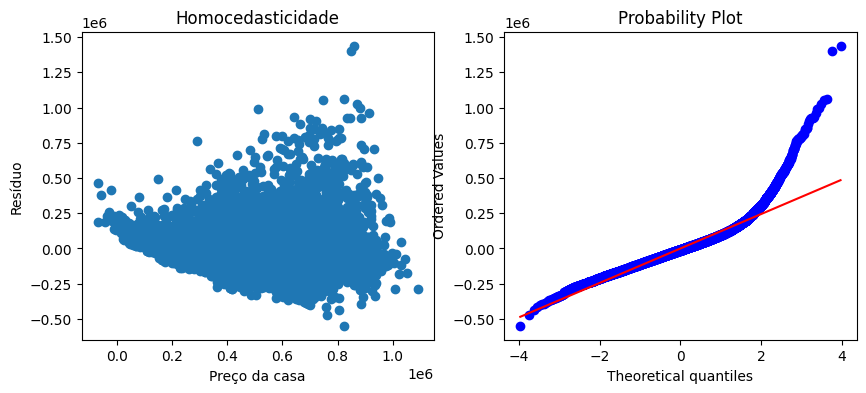

In [18]:
#Armazenando os resíduos obtidos
resultado_reg = results.resid

#Armazenando os valores de preço previstos
y_predict = results.predict(sm.add_constant(X))


fig1 = plt.figure(figsize=(10, 4))
#Verificando a Homocedasticidade
plt.subplot(1,2,1)
plt.scatter(y_predict,resultado_reg)
plt.title("Homocedasticidade")
plt.xlabel("Preço da casa")
plt.ylabel("Resíduo")

#Verificando se os resultados dos residuos obtidos por regressão apresentam distribuição normal
plt.subplot(1,2,2)
stats.probplot(resultado_reg,dist='norm',plot=plt)
plt.show()

Percebe-se que os valores preditos a homocedasticidade varia no modelo, assim, apresenta-se heteroscedasticidade nele. O gráfico da direito também evidência que há variação nos resíduos, pois não seguem a distribuição normal. Os valores de Prob(Omnibus) e Prob(JB) também evidenciam isso pois seus valores, encontrados na terceira tabela,  são menores que alpha normalmente usados que são 1%, 5% ou 10% 

Outra observação interesse, é sobre os valores-p para cada uma das variáveis independentes. Esse valor-p encontrado, se menor que alpha, mostra que aquela variável é relevante para a determinação do preço. Na tabela obtida, percebe-se que o tamanho do lote em square feet (legendada como sqft_lot) apresenta o **valor-p de 0,473**, se mostrando pouco relevante na predição do preço. Numa futura análise essa coluna poderia ser excluída, aplicar o modelo novamente para verficar se ele apresenta uma performace melhor.


## - Decision Tree Regressor

Decision Tree Regressor ou Árvore de Decisão por Regressão é um modelo de predição, normalmente, usado quando a variável de interesse é do tipo contínua.  Para chegar no valor previsto ocorre um processo de tomada de decisões que saem de um ponto de partida e se dividem em outros subconjuntos, ou seja ramificações, assim como as raízes de uma árvore. O ponto de partida é o conjunto com todos dados das variáveis influentes sob a variável de interesse, dentro do modelo ele é chamado de nó raiz.  A separação em subconjuntos é chamado de divisão. Já os subconjuntos podem ser nó de decisão ou (conseguirá criar outros subconjuntos) ou nó de término. Quando um nó gera subconjuntos, ele pode ser chamado de nó pai e seus “descendentes”, os subconjuntos, são chamados de nós filhos, assim como na árvore genealógica.  A figura abaixo apresenta como seria a árvore de decisão:

<img src="img/decisiontree.png" width="500">

Dentro do projeto, o nó raiz são os dados, as sub-árvores são as colunas com as variáveis que interferem para prever o preço da casa e as demais divisões que surgem a partir das colunas e a interação entre elas em cada sub-árvore são feitas na biblioteca sklearn.DecisionTreeRegressor. As próximas células apresentam a implementação da Decision Tree Regressor por meio da biblioteca:


In [19]:
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15']

#selecionando variavel de interesse
y = df.price
#selecionando os dados com base nas features
x = df[features]
#separa os dados em treino e validação
xtreino, xvalidacao, ytreino, yvalidacao = train_test_split(x, y, random_state=1)

# Especificando o modelo
modelo_decisiontree = DecisionTreeRegressor()
# Fit do modelo 
modelo_decisiontree.fit(xtreino, ytreino)

# Especificando o modelo
modelo_decisiontree = DecisionTreeRegressor(random_state=2)
# Fit do modelo 
modelo_decisiontree.fit(xtreino, ytreino)
# Faz a previsão do preço das casas e calcula a média dos erros com base 
val_predictions = modelo_decisiontree.predict(xvalidacao)
val_mae = mean_absolute_error(val_predictions, yvalidacao)
#resultado usando MAE
print(f'Em um primeiro momento, antes da remoção dos outliers o MAE girava em torno de $100.000\n')
print(f'MAE Decision Tree sem outliers: ${val_mae:.2f}\n')
print('Resultado utilizando a função evaluate:\n')
base_accuracy = evaluate(modelo_decisiontree, xvalidacao, yvalidacao)

Em um primeiro momento, antes da remoção dos outliers o MAE girava em torno de $100.000

MAE Decision Tree sem outliers: $73947.28

Resultado utilizando a função evaluate:

Model Performance
Average Error: $73947.28 .
Accuracy = 83.11%.


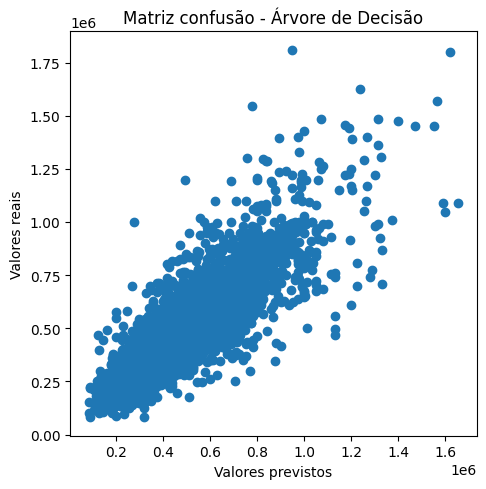

In [20]:
fig1 = plt.figure(figsize=(5.25,5.25))
plt.scatter(val_predictions,yvalidacao)
plt.title("Matriz confusão - Árvore de Decisão")
plt.xlabel("Valores previstos")
plt.ylabel('Valores reais')
plt.show()

## - Random Forest

O Random Forest ou Floresta Aleatória é um método semelhante ao modelo Decision Tree, porém com alterações. A sua estrutura de árvore se mantém (assim como na figura mostrada no Decision Tree) porém como a árvore surge é distinto. O nó raiz, no Decision Tree utiliza todas as variáveis independentes disponíveis no dataset, já no Random Forest a situação muda, o algoritmo por trás do método escolhe aleatoriamente duas ou mais variáveis independentes e a partir delas cria outros nós que serão formados por outras duas ou mais variáveis independentes. Esse processo de gerar uma árvore escolhendo uma parte das variáveis independentes se repete várias vezes. Se temos várias árvores é possível ter uma floresta, por isso surge o nome Floresta Aleatória.

Nas próximas células será aplicado o Random Forest com auxilio da biblioteca sklearn:

In [21]:
#criando o modelo usando random forest depois de ja ter tunado
modelo_randomforest = RandomForestRegressor(random_state=1,n_jobs=6,n_estimators=2000,min_samples_split=5,min_samples_leaf=2,max_depth=50,bootstrap=True)
modelo_randomforest.fit(xtreino, ytreino)
rf_predict = modelo_randomforest.predict(xvalidacao)
rf_mae = mean_absolute_error(rf_predict, yvalidacao)
#resultado utilisando a função MAE
print(f'Random Forest MAE: {rf_mae:.2f}\n')
#resultado utilizando a função evaluate
base_accuracy = evaluate(modelo_randomforest, xvalidacao, yvalidacao)

Random Forest MAE: 51944.13

Model Performance
Average Error: $51944.13 .
Accuracy = 87.98%.


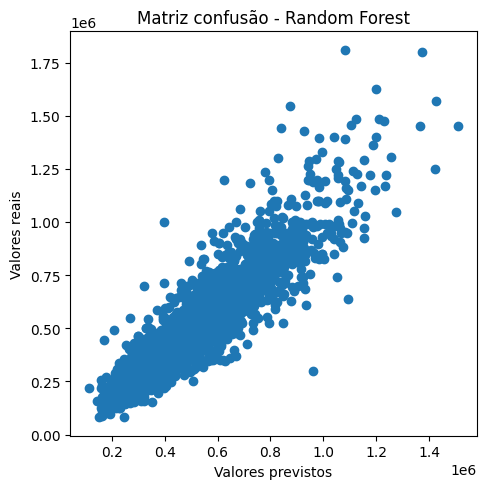

In [22]:
fig1 = plt.figure(figsize=(5.25,5.25))
plt.scatter(rf_predict,yvalidacao)
plt.title("Matriz confusão - Random Forest")
plt.xlabel("Valores previstos")
plt.ylabel('Valores reais')
plt.show()

# - Gradient Boosting

Gradient Boosting é um modelo de predição baseado em Ensemble. O Ensemble se trata de um método que combina modelo mais simples, (chamados de fracos por focarem na otimização de um único ponto, por exemplo, o modelo de Regressão Linear Múltipla focava em minimizar os resíduos entre o valor previsto e o real) pois tem o intuito de construir um modelo mais complexo (forte) a partir dessa combinação de modelos mais fracos. No caso do Gradient Boosting, segundo Victor Teixeira de Melo Mayrink, _o método inicia com uma previsão constante, cujo valor corresponde à média da variável de resposta na amostra de treinamento, depois, a cada interação, um novo termo é adicionado (criando assim uma sequência) ao modelo corrente, com o objetivo de reduzir gradualmente o erro de previsão_. Essa adição de modelos ao Gradient Boosting é a caixa preto por de trás da biblioteca sklearn.ensemble, nas próximas células estará a aplicação desse modelo:

Resultado utilizando a funcao score do sklear: 0.87
Model Performance
Average Error: $50083.11 .
Accuracy = 88.40%.


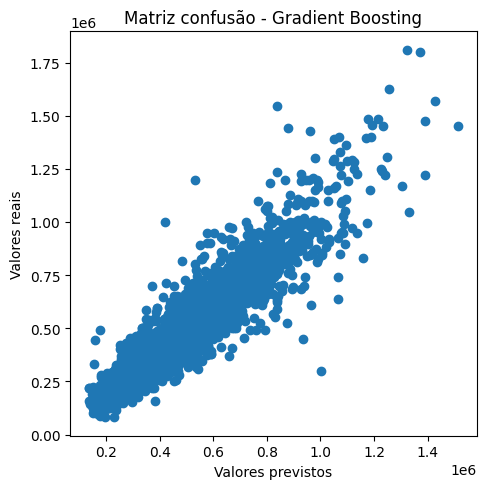

In [23]:
#criando o modelo tunadão 
gbmodel = GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'squared_error')
#treinando o modelo
gbmodel.fit(xtreino, ytreino)
#dando o predict no valor da casa com base nos dados
resultado_gb = gbmodel.predict(xvalidacao)
#resultado utilizando a funcao score
print(f'Resultado utilizando a funcao score do sklear: {gbmodel.score(xvalidacao,yvalidacao):.2f}')
#resultado utilizando a funcao evaluate
base_accuracy = evaluate(gbmodel, xvalidacao, yvalidacao)


fig1 = plt.figure(figsize=(5.25,5.25))
plt.scatter(resultado_gb,yvalidacao)
plt.title("Matriz confusão - Gradient Boosting")
plt.xlabel("Valores previstos")
plt.ylabel('Valores reais')
plt.show()


In [24]:
# Construindo dados para plotar com o displot
def prepare_df_for_plot(real_series, predicted_series):
    rows_real = [{'tipo':'Real', 'Preço da Casa': i} for i in real_series]
    rows_predicao = [{'tipo':'Predição', 'Preço da Casa': i} for i in predicted_series]
    rows = rows_real + rows_predicao
    df = pd.DataFrame(rows)
    return df

df_lr = prepare_df_for_plot(y, y_predict)
df_rf = prepare_df_for_plot(yvalidacao, val_predictions)
df_dt = prepare_df_for_plot(yvalidacao, rf_predict)
df_gb = prepare_df_for_plot(yvalidacao, resultado_gb)

df_lr

,tipo,Preço da Casa
0,Real,221900.000000
1,Real,538000.000000
2,Real,180000.000000
3,Real,604000.000000
4,Real,510000.000000
...,...,...
37063,Predição,510113.737440
37064,Predição,451939.164175
37065,Predição,253125.279812
37066,Predição,421327.040003


# Conclusão

Nós desenvolvemos alguns tipos de modelos com o objetivo de prever o preço de casas com base em suas características. Consideramos o objetivo cumprido, pois os nossos resultados ficaram em torno de 80% de exatidão (87,98% para o Random Forest, 83,11% para o Decision Tree e 88,42% para o Gradient Boosting) e o erro médio das previsões variam de 50 a 74 mil, sendo aproximadamente 50 mil para o Gradient Boosting e 74 mil para o Decision Tree. 

Tal resultado foi obtido por constante melhorias do modelo através de por exemplo tunagem dos parâmetros e limpeza dos dados, remoção dos outliers. Conforme os gráfico abaixo da distribuição de densidade da probabilidade, pode-se perceber como os modelos se adequam ao resultado real:

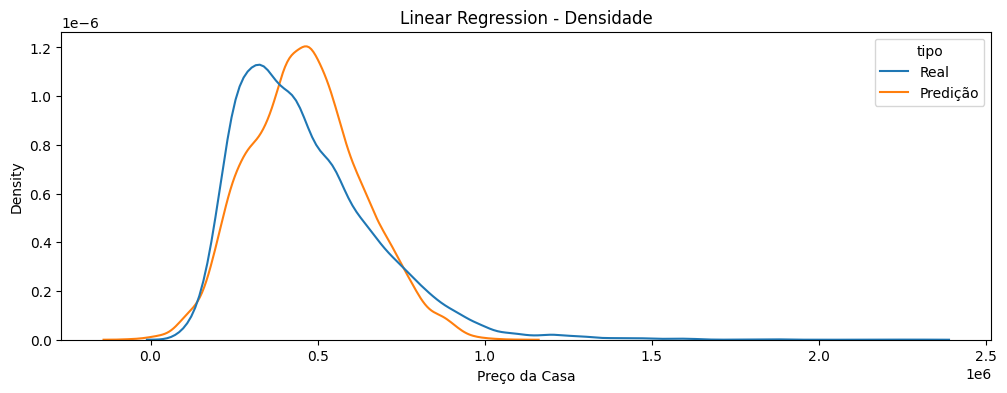

In [25]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.kdeplot(data=df_lr, x='Preço da Casa', hue='tipo', ax=ax)
plt.title("Linear Regression - Densidade")
plt.show()

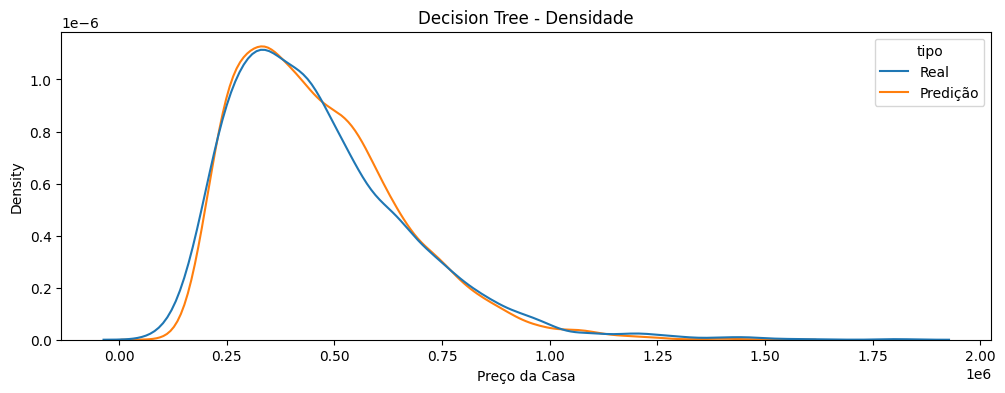

In [26]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.kdeplot(data=df_dt, x='Preço da Casa', hue='tipo', ax=ax)
plt.title("Decision Tree - Densidade")
plt.show()

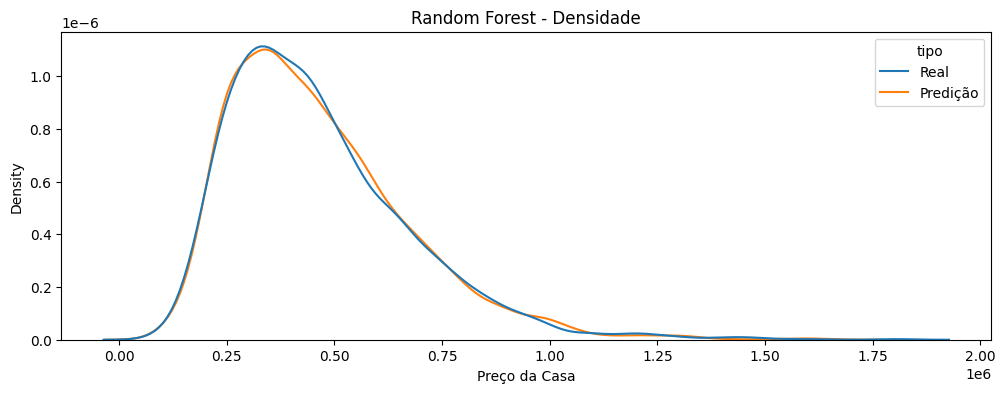

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.kdeplot(data=df_rf, x='Preço da Casa', hue='tipo', ax=ax)
plt.title("Random Forest - Densidade")
plt.show()


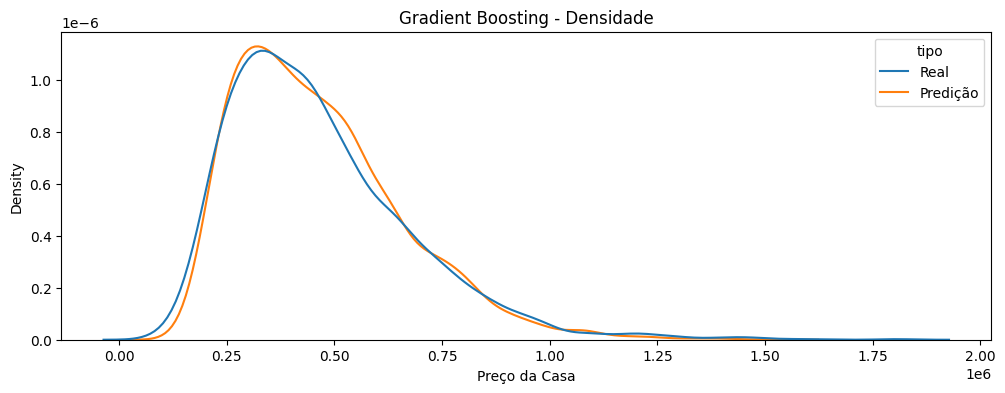

In [28]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.kdeplot(data=df_gb, x='Preço da Casa', hue='tipo', ax=ax)
plt.title("Gradient Boosting - Densidade")
plt.show()


# Referências

[Predicao-de-precos-de-imoveis-atraves-de-aprendizagem-de-maquina](https://www.researchgate.net/profile/Joao_Malere/publication/335392421_Predicao_de_precos_de_imoveis_atraves_de_aprendizagem_de_maquina/links/5d62abce92851c619d76a46e/Predicao-de-precos-de-imoveis-atraves-de-aprendizagem-de-maquina.pdf)

[Avaliacao-de-Imoveis-Urbanos-com-Utilizacao-de-Redes-Neurais-Artificiais.pdf](http://ibape-nacional.com.br/biblioteca/wp-content/uploads/2012/12/Avaliacao-de-Imoveis-Urbanos-com-Utilizacao-de-Redes-Neurais-Artificiais.pdf)

[COMPARAÇÃO ENTRE AS TÉCNICAS DE REGRESSÃO](http://www.coordest.ufpr.br/wp-content/uploads/2018/12/TCC_DanielEricson.pdf)

[DETERMINANTS OF REAL HOUSE PRICE DYNAMICS](https://www.nber.org/papers/w9262.pdf)

[algoritmo-randomforest](https://didatica.tech/o-que-e-e-como-funciona-o-algoritmo-randomforest/)

[modelagem-baseada-em-tree-arvore](https://www.vooo.pro/insights/um-tutorial-completo-sobre-a-modelagem-baseada-em-tree-arvore-do-zero-em-r-python/#:~:text=As%20%C3%A1rvores%20de%20regress%C3%A3o%20s%C3%A3o,valor%20m%C3%A9dio%20das%20suas%20observa%C3%A7%C3%B5es.)

[hyperparameter-tuning](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

[linear-regression-decision-tree](https://medium.com/analytics-vidhya/linear-regression-decision-tree-and-ensemble-learning-applied-to-seoul-housing-prices-830d3493cfdb)

[Algoritmo Gradient Boosting](http://repositorio.ufjf.br:8080/jspui/bitstream/ufjf/3563/1/victorteixeirademelomayrink.pdf)